In [1]:
import random
import math
import numpy as np
from collections import Counter
from matplotlib import pyplot as plt

In [2]:
raw_data = []

with open('../data/transfusion.data') as f:
    f.readline()
    for line in f:
        tokens = line.strip().split(',')
        recency, frequency, monetary, time, _ = tokens
        assert(int(monetary)==int(frequency)*250)
        raw_data.append((int(frequency), int(time)))
n = len(raw_data)
print(n)

748


In [3]:
GS = 800
eps = 1
u_trans = math.ceil(math.log(GS) / math.log(16))

In [4]:
Q = []
Delta_w = []
for left in range(1,51):
    for right in range(left, 51):
        Q.append((left, right))
        Delta_w.append(GS/left)
print(len(Q))

1275


In [5]:
def evaluate(q, raw_histogram, tau=GS):
    ans = 0
    for x in raw_histogram:
        frequency, time = x
        if (frequency >= q[0] and frequency <= q[1]):
            ans += min(time / frequency, tau) * raw_histogram[x]
    return ans

# evaluate a counting query c_{q,tau} on the raw histogram
def evaluate_counting(q, raw_histogram, tau):
    ans = 0
    for x in raw_histogram:
        frequency, time = x
        if (frequency >= q[0] and frequency <= q[1]):
            if (time/frequency > tau):
                ans += raw_histogram[x]
    return ans

In [6]:
# Calculate true results
histogram = Counter(raw_data)
results = [evaluate(q, histogram) for q in Q]

# Composition

In [7]:
eps_0 = eps / (2*len(Q))

results_compo = []
for qi in range(len(Q)):
    q = Q[qi]
    T = np.random.laplace(0, 2 / eps_0) # threshold to compare with
    
    c = evaluate_counting(q, histogram, 0)
    if (c + np.random.laplace(0, 4 / eps_0) <= T):
        results_compo.append(0)
        continue
        
    # else    
    tau = 1
    while (tau < Delta_w[qi]):
        c = evaluate_counting(q, histogram, tau)
        if (c + np.random.laplace(0, 4 / eps_0) <= T):
            ans = evaluate(q, histogram, tau)
            results_compo.append(ans + np.random.laplace(0, tau / eps_0))
            break
        else:
            tau = 2 * tau
    if (tau >= Delta_w[qi]):
        results_compo.append(results[qi] + np.random.laplace(0, Delta_w[qi] / eps_0))

errors_compo = [x-y for x,y in zip(results_compo, results)]

# Normalization

In [8]:
T = 10
eps_0 = eps / (2*T)
universe_size = GS * 50
synthetic_histogram = {}

for frequency in range(1, 51):
    for time in range(1, GS+1):
        synthetic_histogram[(frequency, time)] = n / universe_size

measurements = {}
for i in range(T):
    print("iteration: "+str(i))   

    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram)) / Delta_w[qi] / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / Delta_w[qi]
            for frequency in range(q[0], q[1]+1):
                for time in range(1, GS+1):
                    synthetic_histogram[(frequency, time)] *= math.exp(time / frequency / Delta_w[qi] * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_norm = synthetic_histogram
results_norm = [evaluate(q, synthetic_histogram_norm) for q in Q]
errors_norm = [x-y for x,y in zip(results_norm, results)]

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Global Truncation

In [9]:
weights = [x[1]/x[0] for x in raw_data]

eps_0 = eps / 2
delta_D = GS
T = n + np.random.laplace(0, 2 / eps_0)
c = sum(x <= 0 for x in weights)
if (c + np.random.laplace(0, 4 / eps_0) > T):
    delta_D = 0
else:
    tau = 1
    while (tau < GS):
        c = sum(x <= tau for x in weights)
        if (c + np.random.laplace(0, 4 / eps_0) > T):
            delta_D = tau
            break
        else:
            tau = 2 * tau

In [10]:
T = 10
eps_0 = eps / 2 / (2*T)
universe_size = GS * 50
synthetic_histogram = {}

for frequency in range(1, 51):
    for time in range(1, GS+1):
        synthetic_histogram[(frequency, time)] = n / universe_size

measurements = {}
for i in range(T):
    print("iteration: "+str(i))   

    errors = np.array([])
    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(results[qi] - evaluate(q, synthetic_histogram)) / delta_D / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate(Q[qi], histogram) + np.random.laplace(0, 1.0 / eps_0)
    
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            q = Q[qi]
            error = (measurements[qi] - evaluate(q, synthetic_histogram)) / delta_D
            for frequency in range(q[0], q[1]+1):
                for time in range(1, GS+1):
                    synthetic_histogram[(frequency, time)] *= math.exp(time / frequency / delta_D * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}

synthetic_histogram_glb = synthetic_histogram
results_glb = [evaluate(q, synthetic_histogram_glb) for q in Q]
errors_glb = [x-y for x,y in zip(results_glb, results)]

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


# Ours

In [11]:
T = 10
eps_0 = eps * 0.9 / (2*T)
universe_size = GS * 50
synthetic_histogram = {}

tau_mult = 2
log_tau_mult = int(math.ceil(math.log(GS) / math.log(tau_mult)))

for frequency in range(1, 51):
    for time in range(1, GS+1):
        synthetic_histogram[(frequency, time)] = n / universe_size

measurements = {}

dic = []
for qi in range(len(Q)):
    dic.append((qi, 0, 0))
    tau = 1
    while tau < Delta_w[qi]:
        dic.append((qi, 1, tau))
        dic.append((qi, 0, tau))
        tau *= tau_mult
    dic.append((qi, 1, Delta_w[qi]))

def evaluate_qi(qi, histogram, Q):
    qii, flag, tau = dic[qi]
    if flag == 1:
        return evaluate(Q[qii], histogram, tau) / tau + np.random.laplace(0, 1.0 / eps_0)
    else:
        return evaluate_counting(Q[qii], histogram, tau) + np.random.laplace(0, 1.0 / eps_0)

for i in range(T):
    print("iteration: "+str(i))
    errors = np.array([])

    for qi in range(len(Q)):
        q = Q[qi]
        errors = np.append(errors, eps_0 * abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram, 0)) / 2.0) # counting tau = 0
        tau = 1
        while tau < Delta_w[qi]:
            errors = np.append(errors, \
                               [eps_0 * abs(evaluate(q, histogram, tau) - evaluate(q, synthetic_histogram, tau)) / tau / 2.0,  # truncated by tau \
                                eps_0 * abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram, tau)) / 2.0]) # counting tau

            tau *= tau_mult
        errors = np.append(errors, eps_0 * abs(evaluate(q, histogram, Delta_w[qi]) - evaluate(q, synthetic_histogram, Delta_w[qi])) / Delta_w[qi] / 2.0)
    max_error = errors.max() 
    for qi in range(len(errors)):
        if qi in measurements:
            errors[qi] = 0.0
        else:
            errors[qi] = math.exp(errors[qi]-max_error)
    qi = np.random.choice(range(len(errors)), p=errors / np.sum(errors))
    
    measurements[qi] = evaluate_qi(qi, histogram, Q)
                                   
    total = sum(synthetic_histogram.values())
    for iteration in range(100):
        for qi in measurements:
            qii, flag, tau = dic[qi]
            q = Q[qii]
                                   
            error = measurements[qi] - evaluate_qi(qi, synthetic_histogram, Q)
            for frequency in range(q[0], q[1]+1):
                for time in range(1, GS+1):
                    if (flag == 0): # counting
                        synthetic_histogram[(frequency, time)] *= math.exp(int(time / frequency > tau) * error / (2.0 * total))
                    else: # trunc
                        synthetic_histogram[(frequency, time)] *= math.exp(min(time / frequency , tau) / tau * error / (2.0 * total))
            count = sum(synthetic_histogram.values())
            synthetic_histogram = {k: v*total / count for k,v in synthetic_histogram.items()}
    
synthetic_histogram_trunc = synthetic_histogram

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9


In [12]:
results_trunc = []

errors = []
for qi in range(len(Q)): 
    q=Q[qi]
    errors.append(abs(evaluate_counting(q, histogram, 0) - evaluate_counting(q, synthetic_histogram_trunc, 0))) # counting tau = 0
    tau = 1
    while tau < Delta_w[qi]:
        errors.append(abs(evaluate_counting(q, histogram, tau) - evaluate_counting(q, synthetic_histogram_trunc, tau))) # counting tau
        tau *= tau_mult
max_error = max(errors) + np.random.laplace(10 / eps)
print(max_error)

for qi in range(len(Q)):
    q = Q[qi]
    tau = 0
    c = evaluate_counting(q, synthetic_histogram_trunc, 0)
    if c <= max_error:
        # tau == 0
        results_trunc.append(0)
    else:
        R = 1
        while R < Delta_w[qi]:
            c = evaluate_counting(q, synthetic_histogram_trunc, R)
            if c <= max_error:
                break
            else:
                R *= tau_mult
        tau = min(Delta_w[qi], R)
        res = evaluate(q, synthetic_histogram_trunc, tau)
        results_trunc.append(res)

errors_trunc = [x-y for x,y in zip(results_trunc, results)]

158.4054760936668


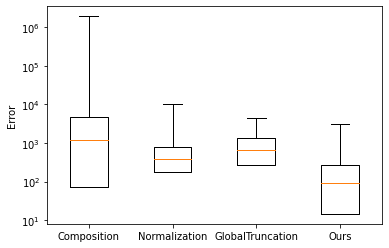

In [13]:
plt.ylabel('Error')
plt.boxplot([[abs(x) for x in errors_compo], [abs(x) for x in errors_norm], [abs(x) for x in errors_glb], [abs(x) for x in errors_trunc]], \
            labels=['Composition', 'Normalization', 'GlobalTruncation', 'Ours'], whis=(25,100), showfliers=False)
plt.yscale("symlog")
plt.show()